<a href="https://colab.research.google.com/github/sampath9dasari/GSU/blob/master/Adverserial_samples_for_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attacking a CNN

In this exercise we will train a CNN to distinguish between instances of handwritten `0` and instances of handwritten `1`. We will be using `keras` to do this.  

Once we have a trained classifier, we will be using `cleverhans` to create adversarial examples.

In [1]:
%tensorflow_version 1.x
!pip install cleverhans

In [2]:
import warnings
import numpy as np
import os
with warnings.catch_warnings():
    import keras # keras is still using some deprectade code
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import BasicIterativeMethod, FastGradientMethod, CarliniWagnerL2
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


The MNIST dataset contains data for all of the digits, but for now we are only interested in 1s and 0s. Therefore we are extracting only those from the dataset. 

We also need to normalize the data. This means that whatever interval was previously covered by the input values will be squashed to `[0,1]`

In [0]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=200 ):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

Load the actual data and use our preprocessing function from earlier.

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )


Keras expects the image to have a color channel. We need to add another dimension to our image to represent
that color channel.

In [0]:
# we need to bring the data in to a format that our cnn likes
y_train = keras.utils.to_categorical( y_train, 2 )
y_test = keras.utils.to_categorical( y_test, 2 )

if keras.backend.image_data_format( ) == 'channels_first':
    x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    input_shape = (1, x_train.shape[ 1 ], x_train.shape[ 2 ])
else:
    x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    input_shape = (x_train.shape[ 1 ], x_train.shape[ 2 ], 1)



We need to make sure that `cleverhans` has access to our model graph. To do this we make sure that `keras` uses the same `tensorflow` session that `cleverhans` will be using. 

In [0]:
# need to some setup so everything gets excecuted in the same tensorflow session
session = tf.Session( )
keras.backend.set_session( session )

We are using a very simple CNN. For our two output classes this is probably overkill. This network can be used to distinguish between all 10 classes with very high accuracy.

In [7]:
# define the classifier
clf = keras.Sequential( )
clf.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=input_shape ) )
clf.add( Conv2D( 64, (3, 3), activation='relu' ) )
clf.add( MaxPooling2D( pool_size=(2, 2) ) )
clf.add( Dropout( 0.25 ) )
clf.add( Flatten( ) )
clf.add( Dense( 128, activation='relu' ) )
clf.add( Dropout( 0.5 ) )
clf.add( Dense( 2, activation='softmax' ) )

clf.compile( loss=keras.losses.categorical_crossentropy,
             optimizer='adam',
             metrics=[ 'accuracy' ] )

clf.fit( x_train, y_train,
         epochs=16,
         verbose=0 )
#clf.summary( )
score = clf.evaluate( x_test, y_test, verbose=0 )
print( 'Test loss:', score[ 0 ] )
print( 'Test accuracy:', score[ 1 ] )







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Test loss: 0.00027859471534611655
Test accuracy: 1.0


Let's get to the actual attack magic. First we are picking a sample that we want to perturbate. After that we will be implementing our own FGSM attack. We will make use of the `KerasModelWrapper` from `cleverhans`. Which offers a few convience functions like obtaining the `logits` layer easily.


The attack is fairly simple. It consists of the following steps: 

1.   Compute the loss of the original sample
2.   Calculate the gradient of the loss wrt the input 
3.   Take the sign of the gradient and add a fraction episilon to the input.

Epsilon controlls the strenght of the pertubation.


In [8]:
clf

(28, 28, 1)


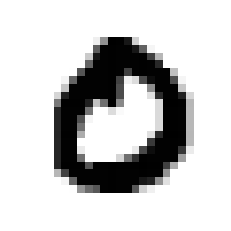

class prediction for the test samples: [[1.000000e+00 7.258264e-09]]
1.00,0.00
Tensor("softmax_cross_entropy_with_logits_15/Reshape_2:0", shape=(1,), dtype=float32)


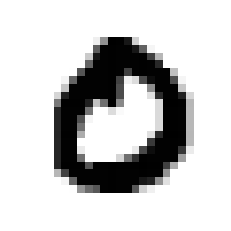

[[1.3513601e-06 9.9999869e-01]]
0.00,1.00


In [24]:
from cleverhans.compat import softmax_cross_entropy_with_logits

#chose a sample to pertubate
sample_ind = 100 # chosen by totaly random dice roll

# picking a test sample
sample = x_test[ sample_ind, : ]
true_label = y_test[ sample_ind, : ]

print( sample.shape )

# plot the first instance in the traning set
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

# constructing adversarial examples
class_pred = clf.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )
print( 'class prediction for the test samples:', class_pred)

print("%.2f,%.2f"%tuple(class_pred.reshape(2)))

# setup the attack
wrapper = KerasModelWrapper( clf )
eps = 0.5 # allowed maximum modification

# setup the compuation graph
# gather all the required info
x = clf.layers[ 0 ].input
y = tf.placeholder( tf.float32, shape=y_test[ sample_ind, : ].shape )
logits = wrapper.get_logits( x )

######################
# fill in the blanks #
######################


# compute the loss of our original sample
loss = softmax_cross_entropy_with_logits(labels=y,logits=logits)
print(loss)
# clf.predict(sample)

# get the gradient wrt to the input.
grads = tf.gradients(loss,x)

# calculate the pertubation
pert = eps*tf.sign(grads)

# apply pertubation
ae = x + pert

#get the correct label
true_label = y_test[ sample_ind, : ]

# now that we have the graph set up we need to run it
output = session.run( ae, feed_dict={x: sample.reshape(1,28,28,1), y : true_label} )

# execute the graph to create an adversarial example
sample_pred = clf.predict(output[0])

# get the prediction result and print the adversarial example

plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )
print(sample_pred)
print("%.2f,%.2f"%tuple(sample_pred.reshape(2)))

The FGSM is one of the most simple attacks. As we can see that results are not very convincing. We can improve on it by making it iterative. 

Using the code from above, create an iterative version of FGSM that calculates a new pertubation for ever iteration and stops once it achieve misclassifaction.



In [0]:
# your code here

Let's get to the actual attack magic. First we are picking a sample that we want to perturbate. After selecting the sample, we will use the FGSM attack and the Carlini & Wagner L2 attack to perturbate it into an adversarial example.

[INFO 2020-02-10 21:03:52,805 cleverhans] Constructing new graph for attack FastGradientMethod


Instructions for updating:
Use `tf.cast` instead.
class prediction for the modified test samples: [[6.63539e-16 1.00000e+00]]


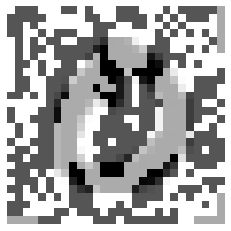

[INFO 2020-02-10 21:03:53,195 cleverhans] Constructing new graph for attack CarliniWagnerL2



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


class prediction for the cw modified test samples: [[0.49989983 0.50010014]]


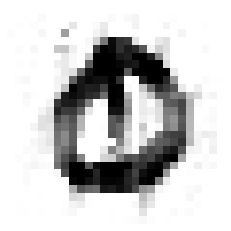

In [26]:
# using the ceverhans implemenation
fgm = FastGradientMethod( wrapper, sess=session )
eps = 1.0 # allowed maximum modification

# excetute the attack
with warnings.catch_warnings():
    modified_sample = fgm.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ),
                                   **{ 'eps': eps } )

print( 'class prediction for the modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )
plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

params = { 'binary_search_steps': 1,
            'max_iterations': 100,
            'learning_rate': .2,
            'initial_const': 10 }

# let's try a stronger attack
with warnings.catch_warnings():
    cw_l2 = CarliniWagnerL2( wrapper, sess=session )
    modified_sample = cw_l2.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print( 'class prediction for the cw modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )
plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )


We have seen that FGSM does not do a great job of producing adversarial examples when work with 0 and 1. Update the code above work on all 10 digits and try for a number of 0 instance what class they get transformed into in an untargeted attack.
Alternativley pick a pair of numbers that you think are closer to each orther and the FGSM attack should work better with.


`cleverhans` provides more attacks than the once introdcued above. Try the JSM attack or virtual adversary.

You can find more information on the attacks here: https://github.com/tensorflow/cleverhans/tree/master/cleverhans/attacks


In [0]:
# your code here